### Point 7: The candidate is required to analyze in more depth the characteristics of the chosen techniques. Moreover, the candidate is required to explain how these characteristics affect the results reported in Appendix C. 
**This notebook presents a comprehensive analysis of the modifications made to the equation.**

In [2]:
import pandas as pd
import seaborn as sb
import math
import numpy as np
import os
import re
import jenkspy
from ast import literal_eval

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv("df_mfeatures.csv")
df2 = pd.read_csv("df_ensemble_allfeatures.csv")

binDF = pd.read_csv("BinnedMetaFeatures.csv")

In [4]:
df_new = df1[['File', 'Completeness', 'Conciseness', 'cor.mean', 'cov.mean',
       'eigenvalues.mean', 'g_mean.mean', 'h_mean.mean', 'iq_range.mean', 'kurtosis.mean', 
       'mad.mean', 'max.mean', 'mean.mean', 'median.mean', 'min.mean', 'nr_cor_attr',
       'nr_norm', 'nr_outliers', 'range.mean', 'sd.mean', 'skewness.mean',
       'sparsity.mean', 't_mean.mean',   'var.mean', 'ClassImbRatio',
       'ClassOverlapPerc', 'OutlierPerc', 'attr_to_inst', 'inst_to_attr', 'nr_attr',
        'nr_bin',  'nr_inst', 'nr_num', 'attr_conc.mean', 'attr_ent.mean', 'ena', 'nUnique' ,'snr.mean', 'cEntropy','LabelIssuesPerc']] #SyntaxAccuracy removed

df_bin_new = binDF[['Completeness_bins', 'Conciseness_bins',  'cor.mean_bins', 'cov.mean_bins', 
              'eigenvalues.mean_bins', 'g_mean.mean_bins', 'h_mean.mean_bins', 'iq_range.mean_bins', 'kurtosis.mean_bins',
              'mad.mean_bins', 'max.mean_bins',  'mean.mean_bins', 'median.mean_bins',  'min.mean_bins', 'nr_cor_attr_bins', 
              'nr_norm_bins', 'nr_outliers_bins', 'range.mean_bins', 'sd.mean_bins', 'skewness.mean_bins',
              'sparsity.mean_bins', 't_mean.mean_bins', 'var.mean_bins', 'LabelIssues_bins', 'ClassImbRatio_bins', 
              'OutlierPerc_bins', 'ClassOverlapPerc_bins', 'attr_to_inst_bins', 'inst_to_attr_bins', 'nr_attr_bins',
              'nr_inst_bins', 'nr_num_bins', 'nr_bin_bins', 'attr_conc.mean_bins', 'cEntropy_bins', 'ena_bins', 'snr.mean_bins', 'nUnique_bins','attr_ent.mean_bins', 'File']] #'SyntaxAccuracy_bins' removed

In [5]:
def extract_rows(df, alpha, beta, sort):
    earr = []
    fmrr = []
    fwrr = []
    no_of_feature_algo = 9
    total_comb = no_of_feature_algo * (no_of_feature_algo-1)

    df['F1 macro'] = (2*df['Precision macro']*df['Recall macro']) / (df['Precision macro'] + df['Recall macro'])
    df['F1 weight'] = (2*df['Precision weight']*df['Recall weight']) / (df['Precision weight'] + df['Recall weight'])
    x = 1
    count = 0
    for i in range(0, df.shape[0]): #dataset
      tempfmrr = []
      tempfwrr = []
      tempearr = []
      for j in range(9):
        if (i!=j+9*(x-1)):
          tempearr.append((df['Accuracy'][i] / df['Accuracy'][j+9*(x-1)]) /( 1 + (alpha*  math.log10(df['Time FS'][i] / df['Time FS'][j+9*(x-1)])) +( beta * math.log10(df['Features'][i]/ df['Features'][j+9*(x-1)]))))
          tempfmrr.append((df['F1 macro'][i] / df['F1 macro'][j+9*(x-1)]) /( 1 + (alpha* math.log10(df['Time FS'][i] / df['Time FS'][j+9*(x-1)])) +( beta * math.log10(df['Features'][i]/ df['Features'][j+9*(x-1)]))))
          tempfwrr.append((df['F1 weight'][i] / df['F1 weight'][j+9*(x-1)]) /( 1 + (alpha* math.log10(df['Time FS'][i] / df['Time FS'][j+9*(x-1)])) +( beta * math.log10(df['Features'][i]/ df['Features'][j+9*(x-1)]))))

          count=count+1

          if count==total_comb:
            x=x+1
            count=0
            break
      earr.append(sum(tempearr)/(no_of_feature_algo-1))
      fmrr.append(sum(tempfmrr)/(no_of_feature_algo-1))
      fwrr.append(sum(tempfwrr)/(no_of_feature_algo-1))
    
    df['earr'] = earr
    df['fmrr'] = fmrr
    df['fwrr'] = fwrr
    df1 = df.sort_values(['File',sort], ascending=[1,False])
    df3 = df1.groupby('File').first().reset_index()
    return df3

In [6]:
root = './optimalalphabeta/dearr_cont/'
for i in np.arange(0, 0.11, 0.02):
    for j in np.arange(0,0.11, 0.02):
        df_optimal = extract_rows(df2, i, j, 'earr')
        merge_features = pd.merge(df_new, df_optimal[['File','FeatureAlgo']], on=['File'])
        merge_features.to_csv(root+"dearr"+str(i)+"_"+str(j)+".csv", index=False)

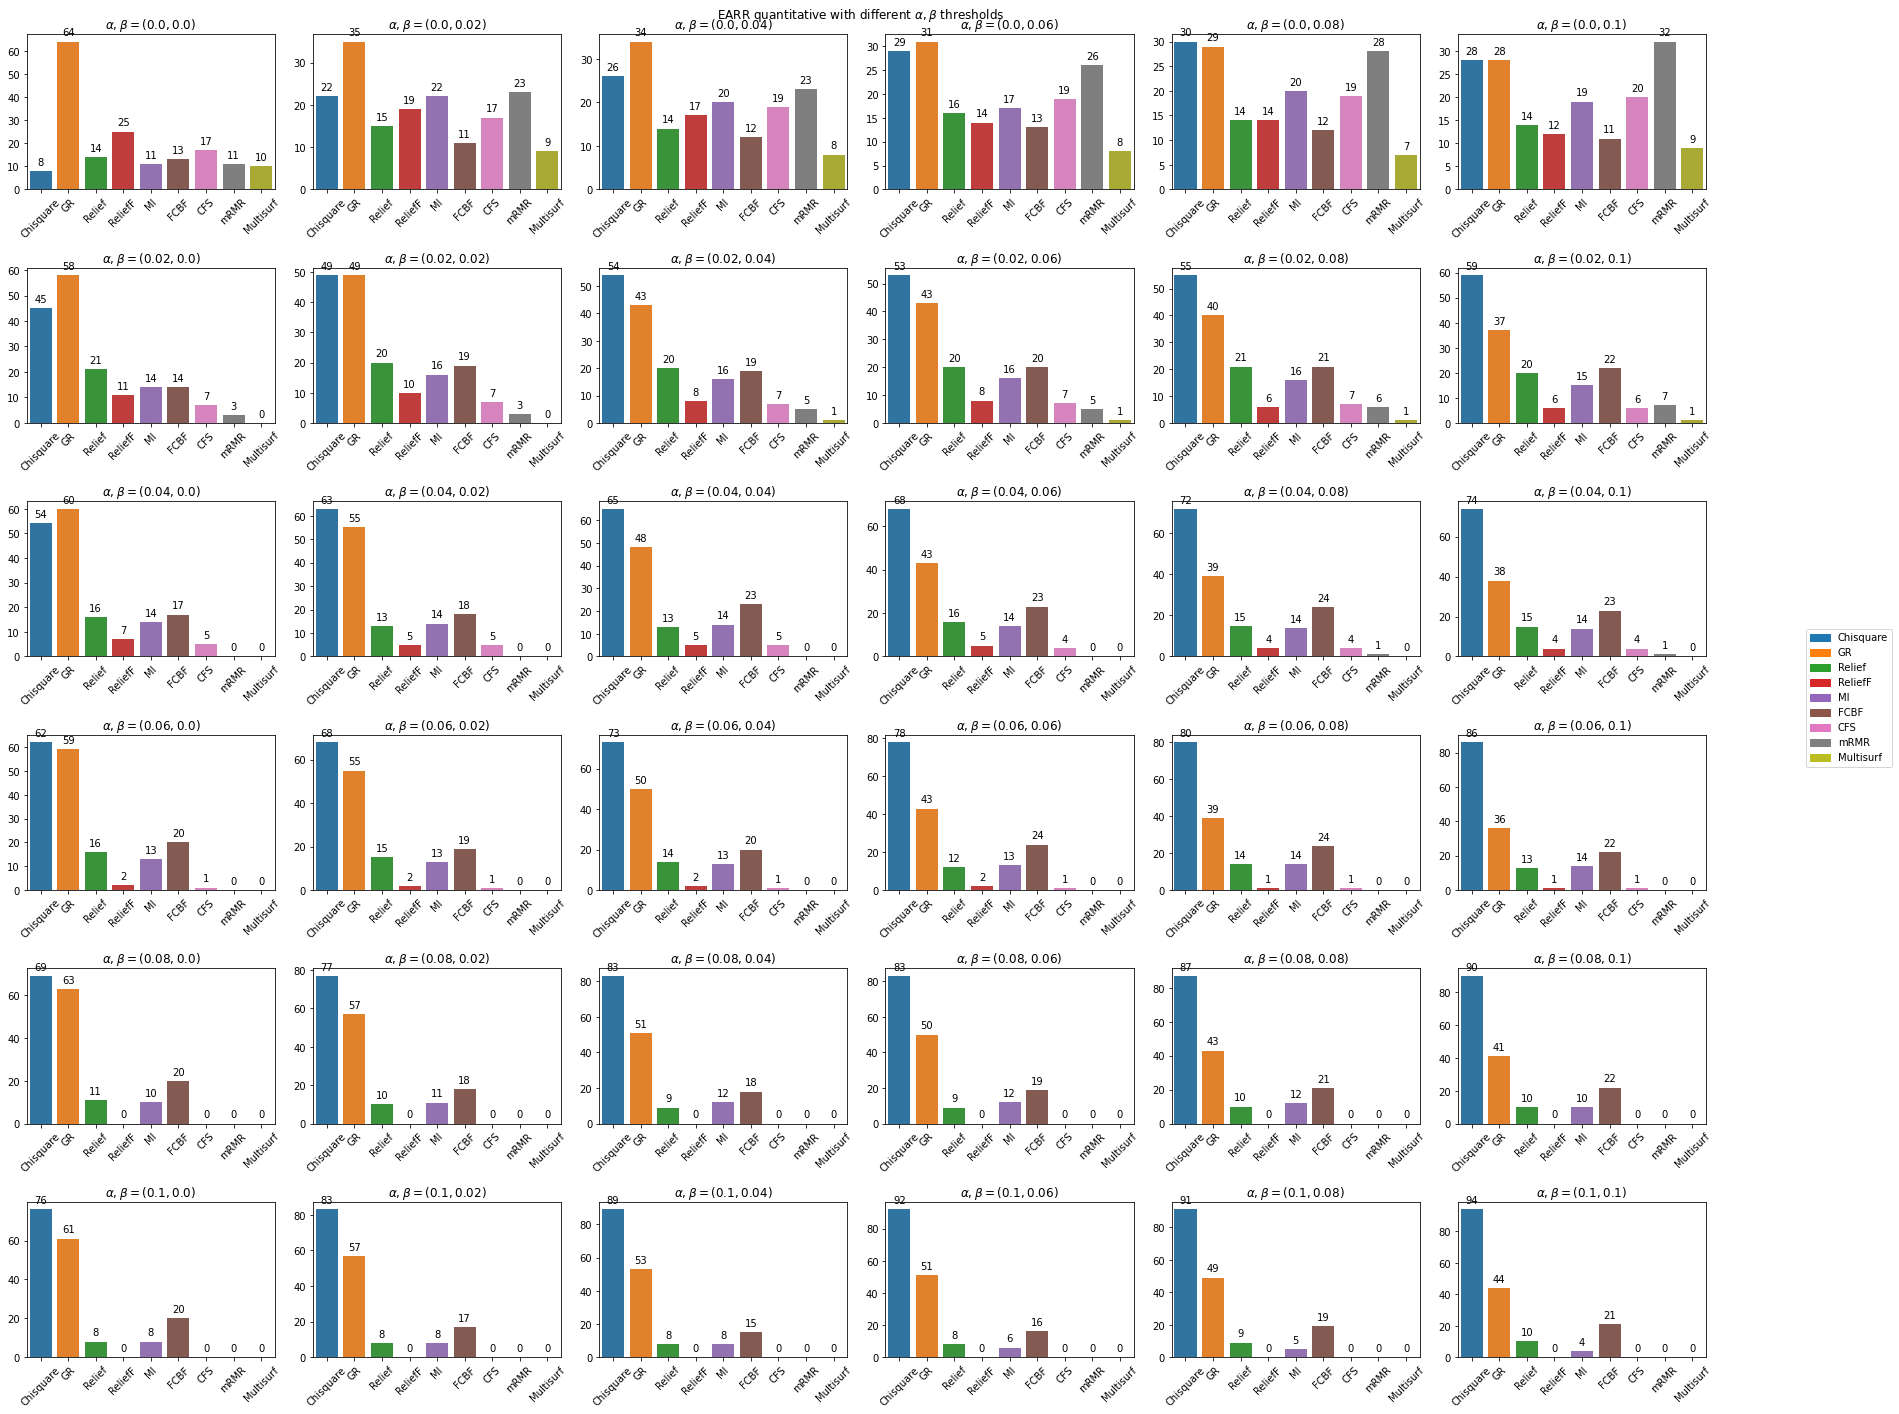

In [7]:
feature_algos = [
    'chisquare', 'GR', 'relief', 'relieff', 'MI',
    'fcbf', 'cfs', 'mrmr', 'multisurf'
]
renamed_algos = [
    'Chisquare', 'GR', 'Relief', 'ReliefF', 'MI',
    'FCBF', 'CFS', 'mRMR', 'Multisurf'
]
rename_dict = dict(zip(feature_algos, renamed_algos))

palette = sns.color_palette("tab10", len(feature_algos))
color_dict = {renamed_algos[i]: palette[i] for i in range(len(feature_algos))}

abs_path = "./optimalalphabeta/dearr_cont"

file_info = []
for file in os.listdir(abs_path):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)  # Convert to float
        file_info.append((alpha, beta, file))

file_info.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 20), tight_layout=True)
fig.suptitle('EARR quantitative with different ' + r'$\alpha, \beta$' + ' thresholds')

results = []

for idx, (alpha, beta, file) in enumerate(file_info):
    df = pd.read_csv(os.path.join(abs_path, file))
    df['FeatureAlgo'] = df['FeatureAlgo'].map(rename_dict)  # Rename the algorithms
    value_counts = df['FeatureAlgo'].value_counts().reindex(renamed_algos, fill_value=0)
    
    results.append([alpha, beta] + value_counts.tolist())
    
    row, col = divmod(idx, 6)
    ax = axes[row][col]
    
    sns.barplot(ax=ax, x=value_counts.index, y=value_counts.values, palette=[color_dict[algo] for algo in value_counts.index])
    ax.set_title(r'$\alpha, \beta = ({}, {})$'.format(alpha, beta))
    ax.set_xticklabels(labels=value_counts.index, rotation=45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

df_results = pd.DataFrame(results, columns=['alpha', 'beta'] + renamed_algos)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.4)

handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(renamed_algos))]
labels = renamed_algos
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

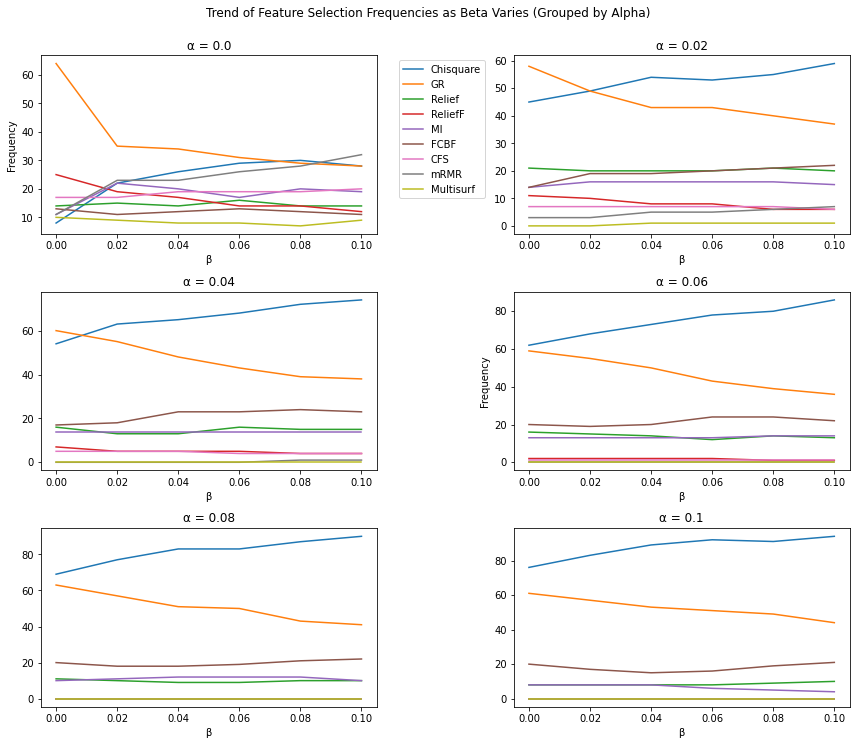

In [8]:
unique_alphas = sorted(df_results['alpha'].unique())

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

algorithms = df_results.columns[2:]

for i, alpha_val in enumerate(unique_alphas):
    ax = axs[i]
    
    df_alpha = df_results[df_results['alpha'] == alpha_val]
    
    for algo in algorithms:
        ax.plot(df_alpha['beta'], df_alpha[algo], label=algo)
    
    ax.set_title(f'α = {alpha_val}')
    ax.set_xlabel('β')
    if i % 3 == 0:
        ax.set_ylabel('Frequency')
    ax.grid(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("Trend of Feature Selection Frequencies as Beta Varies (Grouped by Alpha)", y=1.03)
plt.show()

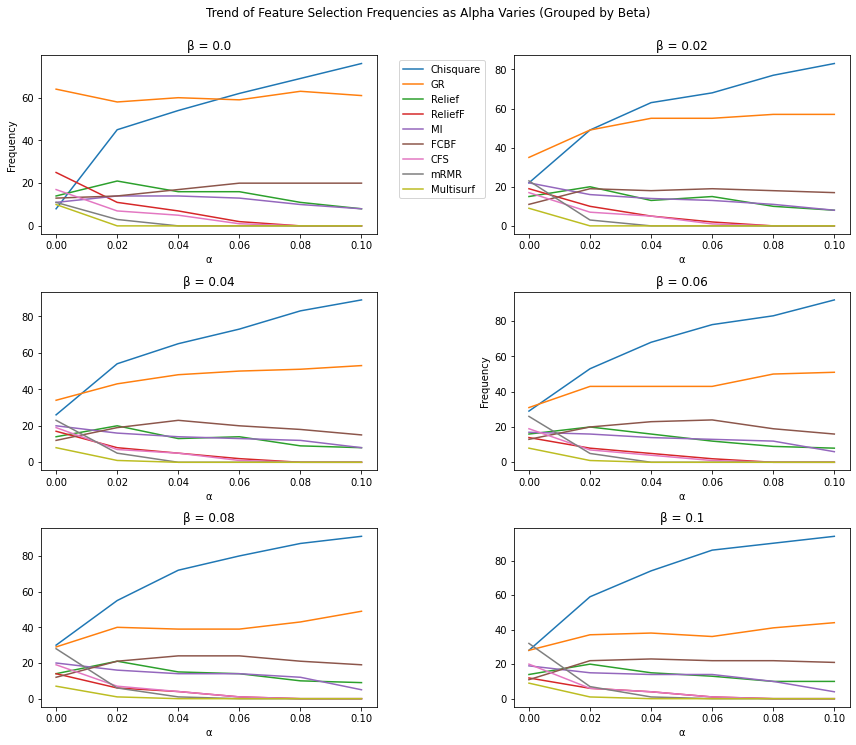

In [9]:
unique_alphas = sorted(df_results['beta'].unique())

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

algorithms = df_results.columns[2:]

for i, alpha_val in enumerate(unique_alphas):
    ax = axs[i]
    
    df_alpha = df_results[df_results['beta'] == alpha_val]
    
    for algo in algorithms:
        ax.plot(df_alpha['alpha'], df_alpha[algo], label=algo)
    
    ax.set_title(f'β = {alpha_val}')
    ax.set_xlabel('α')
    if i % 3 == 0:
        ax.set_ylabel('Frequency')
    ax.grid(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("Trend of Feature Selection Frequencies as Alpha Varies (Grouped by Beta)", y=1.03)
plt.show()

The frequency of feature selection is nonlinear for many methods.  In particular, the frequency of GR and Chisquare flipped when the shift occurred from alpha = 0.08 to alpha = 0.1. As a result, all datasets which got chisquare as label when alpha is.08 and  GR as label when alpha is 0.1 are examined separately.  

In [10]:
df_results

,alpha,beta,Chisquare,GR,Relief,ReliefF,MI,FCBF,CFS,mRMR,Multisurf
0,0.00,0.00,8,64,14,25,11,13,17,11,10
1,0.00,0.02,22,35,15,19,22,11,17,23,9
2,0.00,0.04,26,34,14,17,20,12,19,23,8
3,0.00,0.06,29,31,16,14,17,13,19,26,8
4,0.00,0.08,30,29,14,14,20,12,19,28,7
5,0.00,0.10,28,28,14,12,19,11,20,32,9
6,0.02,0.00,45,58,21,11,14,14,7,3,0
7,0.02,0.02,49,49,20,10,16,19,7,3,0
8,0.02,0.04,54,43,20,8,16,19,7,5,1
9,0.02,0.06,53,43,20,8,16,20,7,5,1


In [10]:
directory = "./optimalalphabeta/dearr_cont_old"

target_params = [(0.08, 0.0), (0.1, 0.0)]

chisquare_datasets = {}
GR_datasets = {}
abs_path = "./optimalalphabeta/dearr_cont_old"

for file in os.listdir(directory):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)
        if (alpha, beta) in target_params:
            df = pd.read_csv(os.path.join(directory, file))
            selected_chisquare = df[df['FeatureAlgo'] == 'chisquare']['File'].tolist()
            selected_GR = df[df['FeatureAlgo'] == 'GR']['File'].tolist()
            chisquare_datasets[(alpha, beta)] = selected_chisquare
            GR_datasets[(alpha, beta)] = selected_GR

alpha_08_chi = set(chisquare_datasets.get((0.08, 0.0), []))
alpha_10_chi = set(chisquare_datasets.get((0.10, 0.0), []))

alpha_08_gr = set(GR_datasets.get((0.08, 0.0), []))
alpha_10_gr = set(GR_datasets.get((0.10, 0.0), []))

common_chi = alpha_08_chi & alpha_10_chi
only_in_08_chi = alpha_08_chi - alpha_10_chi
only_in_10_chi = alpha_10_chi - alpha_08_chi

common_chi08_gr01 = alpha_10_gr & alpha_08_chi
print((common_chi08_gr01))

#print("Datasets for alpha=0.08, beta=0.0:", alpha_08)
#print("Datasets for alpha=0.10, beta=0.0:", alpha_10)
#print("Common datasets:", len(common_chi))
#print("Only in alpha=0.08:", len(only_in_08_chi))
#print("Only in alpha=0.10:", len(only_in_10_chi))

set()


The denominator of the EARR formula incorporates logarithmic terms that compare the execution time ($t$) and the number of features selected ($n$) by a given technique $F_i^k$ relative to another technique $F_j^k$ for a dataset $k$. When $t_j^k$ is substantially larger than $t_i^k$ or  
 $n_j^k$ is substantially larger than $n_i^k$, the respective resulting ratios $\frac{t_i^k}{t_j^k}$ or $\frac{n_i^k}{n_j^k}$ fall below 1. Consequently, the logarithmic terms yield negative values. In certain cases, this leads to a negative denominator, which in turn produces a negative EARR score. This effect reduces the average EARR for $F_i$ and contributes to inconsistencies in the ranking of feature selection techniques.

This behavior was manually verified through independent calculations of the EARR scores and helps explain the irregular selection patterns observed for specific techniques such as Gain Ratio (GR) and Chi-Square.


The following dataset samples were selected to support this verification.



In [ ]:
#Some files which are common between Chisquare (alpha = 0.08) and  GR (alpha = 0.1)

data = [
    ['yeast4.csv', 'GR', 0.962962962962963, 0.011068681997131, 3],
    ['yeast4.csv', 'fcbf', 0.962962962962963, 0.007304289989406, 3],
    ['yeast4.csv', 'relieff', 0.962962962962963, 2.11929961200804, 5],
    ['yeast4.csv', 'chisquare', 0.95959595959596, 0.004200452996884, 2],
    ['yeast4.csv', 'cfs', 0.962962962962963, 0.166411410988076, 3],
    ['yeast4.csv', 'multisurf', 0.966329966329966, 216.745115896003, 3],
    ['yeast4.csv', 'MI', 0.962962962962963, 0.043617727002129, 3],
    ['yeast4.csv', 'mrmr', 0.962962962962963, 3.37605232201167, 3],
    ['yeast4.csv', 'relief', 0.962962962962963, 0.027662977998261, 5]
]

data = [['Raisin_Dataset',	'GR',	0.872222222222222,	0.007768206996843,	6],
['Raisin_Dataset',	'fcbf',	0.844444444444444,	0.007718241002294,	1],
['Raisin_Dataset',	'relieff',	0.872222222222222,	1.14455321300193,	6],
['Raisin_Dataset',	'chisquare',	0.838888888888889,	0.00450773499324,	2],
['Raisin_Dataset',	'cfs',	0.872222222222222,	0.173946502007311,	6],
['Raisin_Dataset',	'multisurf',	0.872222222222222,	130.6466697,	6],
['Raisin_Dataset',	'MI',	0.861111111111111,	0.04049015599594,	4],
['Raisin_Dataset',	'mrmr',	0.861111111111111,	3.22367834500619,	4],
['Raisin_Dataset',	'relief',	0.838888888888889,	0.017976064002141,	2]
]

data = [['PhishingData',	'GR',	0.785977859778598,	0.015703155004303,	3],
['PhishingData',	'fcbf',	0.785977859778598,	0.009121683993726,	3],
['PhishingData',	'relieff', 0.77859778597786,	1.87732101298752,	6],
['PhishingData',	'chisquare',	0.785977859778598,	0.006597834013519,	3],
['PhishingData',	'cfs',	0.785977859778598,	0.163483525000629,	3],
['PhishingData',	'multisurf',	0.619926199261993,	227.059984995998,	3],
['PhishingData',	'MI',	0.804428044280443,	0.049169759004144,	4],
['PhishingData',	'mrmr',	0.785977859778598,	3.54739922500448,	3],
['PhishingData',	'relief',	0.822878228782288,	0.022548692999408,6]]

data = [['car',	'GR',	0.757225433526012,	0.016368751999835,	2],
['car',	'fcbf',	0.684971098265896,	0.007708166998782,	2],
['car',	'relieff',	0.760115606936416,	2.66249974400125,	3],
['car',	'chisquare',	0.757225433526012,	0.003959164998378,	2],
['car',	'cfs',	0.757225433526012,	0.091644891999749,	2],
['car',	'multisurf',	0.684971098265896,	216.201338653998,	2],
['car',	'MI',	0.757225433526012,	0.041729112999747,	2],
['car',	'mrmr',	0.757225433526012,	2.48608231099934,	2],
['car',	'relief',	0.757225433526012,	0.021723105001001,	2]]

data = [['yeast6',	'GR',	0.962962962962963,	0.01173755300988,	3],
['yeast6',	'fcbf',	0.962962962962963,	0.007161069006543,	3],
['yeast6',	'relieff',	0.983164983164983,	2.03800448300899,	5],
['yeast6',	'chisquare',	0.966329966329966,	0.004521584996837,	2],
['yeast6',	'cfs',	0.976430976430976,	0.163089395005954,	3],
['yeast6',	'multisurf',	0.973063973063973,	207.710269186005,	3],
['yeast6',	'MI',	0.966329966329966,	0.041389289996005,	2],
['yeast6',	'mrmr',	0.966329966329966,	3.47491513499699,	2],
['yeast6',	'relief',	0.97979797979798,	0.026419079003972,	6]
]

In [24]:
data = [['car',	'GR',	0.757225433526012,	0.016368751999835,	2],
['car',	'fcbf',	0.684971098265896,	0.007708166998782,	2],
['car',	'relieff',	0.760115606936416,	2.66249974400125,	3],
['car',	'chisquare',	0.757225433526012,	0.003959164998378,	2],
['car',	'cfs',	0.757225433526012,	0.091644891999749,	2],
['car',	'multisurf',	0.684971098265896,	216.201338653998,	2],
['car',	'MI',	0.757225433526012,	0.041729112999747,	2],
['car',	'mrmr',	0.757225433526012,	2.48608231099934,	2],
['car',	'relief',	0.757225433526012,	0.021723105001001,	2]]

df = pd.DataFrame(data, columns=['Dataset', 'FeatureAlgo', 'Accuracy', 'Time', 'NumFeatures'])

alpha = 0.1
beta = 0.02

def calculate_earr(acc_i, acc_j, time_i, time_j, n_i, n_j, alpha, beta):
    numerator = acc_i / acc_j
    denominator = 1 + alpha * math.log10(time_i / time_j) + beta * (math.log10(n_i / n_j))
    return numerator / denominator

earr_results = {}
for i, row_i in df.iterrows():
    algo_i = row_i['FeatureAlgo']
    acc_i = row_i['Accuracy']
    time_i = row_i['Time']
    n_i = row_i['NumFeatures']
    
    earr_sum = 0
    count = 0
    arr = []
    for j, row_j in df.iterrows():
        if i != j:
            acc_j = row_j['Accuracy']
            time_j = row_j['Time']
            n_j = row_j['NumFeatures']
            earr = calculate_earr(acc_i, acc_j, time_i, time_j, n_i, n_j, alpha, beta)
            arr.append(round(earr,2))
            earr_sum += earr
            count += 1
    earr_results[algo_i] = earr_sum / count
    print(algo_i, arr)
for algo, avg_earr in earr_results.items():
    print(f"{algo}: Average EARR = {avg_earr:.4f}")

GR [1.07, 1.28, 0.94, 1.08, 1.88, 1.04, 1.28, 1.01]
fcbf [0.94, 1.21, 0.88, 1.01, 1.8, 0.98, 1.21, 0.95]
relieff [0.82, 0.88, 0.78, 0.87, 1.37, 0.85, 1.0, 0.83]
chisquare [1.07, 1.14, 1.4, 1.16, 2.1, 1.11, 1.39, 1.08]
cfs [0.93, 1.0, 1.17, 0.88, 1.67, 0.97, 1.17, 0.94]
multisurf [0.64, 0.69, 0.76, 0.61, 0.68, 0.66, 0.76, 0.65]
MI [0.96, 1.03, 1.22, 0.91, 1.04, 1.76, 1.22, 0.97]
mrmr [0.82, 0.88, 1.0, 0.78, 0.87, 1.37, 0.85, 0.83]
relief [0.99, 1.06, 1.26, 0.93, 1.07, 1.84, 1.03, 1.26]
GR: Average EARR = 1.1990
fcbf: Average EARR = 1.1217
relieff: Average EARR = 0.9243
chisquare: Average EARR = 1.3051
cfs: Average EARR = 1.0905
multisurf: Average EARR = 0.6807
MI: Average EARR = 1.1377
mrmr: Average EARR = 0.9267
relief: Average EARR = 1.1798


As illustrated in the example above, the average EARR value is observed to be negative for certain feature selection techniques, despite the expectation—established by the authors in \cite{wang2013}—that it should be around 1. This problem primarily arises when a particular technique, such as MultiSurf, requires significantly more execution time compared to others like Chi-Square or Gain Ratio, resulting in extremely small ratios and consequently negative logarithmic values. Out of all cases, the negative logarithmic values led to a negative denominator in two cases, which resulted in a negative EARR score. This reduced the average EARR for FCBF and Chisquare. In the remaining cases where the logarithmic terms yield negative values, the resulting reduction in the denominator leads to a disproportionately high EARR score. This bias significantly affects the ranking of feature selection algorithms for specific datasets.

To mitigate this issue, a constant value of 1 is added within the logarithmic expressions. This adjustment ensures that the input to the logarithm remains greater than 1, thereby avoiding negative outputs and maintaining EARR values closer to the expected range. Specifically, when the ratio is exceedingly small, the addition of 1 shifts the value above 1, effectively raising the lower bound of the logarithmic term.

The experiment is subsequently repeated with this modification applied to the logarithmic terms.

In [89]:
#same experiment with log(1+t_i/t_j) and log(1+n_i/n_j)

data = [['PhishingData',	'GR',	0.785977859778598,	0.015703155004303,	3],
['PhishingData',	'fcbf',	0.785977859778598,	0.009121683993726,	3],
['PhishingData',	'relieff', 0.77859778597786,	1.87732101298752,	6],
['PhishingData',	'chisquare',	0.785977859778598,	0.006597834013519,	3],
['PhishingData',	'cfs',	0.785977859778598,	0.163483525000629,	3],
['PhishingData',	'multisurf',	0.619926199261993,	227.059984995998,	3],
['PhishingData',	'MI',	0.804428044280443,	0.049169759004144,	4],
['PhishingData',	'mrmr',	0.785977859778598,	3.54739922500448,	3],
['PhishingData',	'relief',	0.822878228782288,	0.022548692999408,6]]


df = pd.DataFrame(data, columns=['Dataset', 'FeatureAlgo', 'Accuracy', 'Time', 'NumFeatures'])

alpha = 0.1
beta = 0.2

def calculate_earr(acc_i, acc_j, time_i, time_j, n_i, n_j, alpha, beta):
    numerator = acc_i / acc_j
    denominator = 1 + alpha * (math.log(1 + time_i / time_j)) + beta * ((math.log(1 + n_i / n_j)))
    return numerator / denominator

earr_results = {}
for i, row_i in df.iterrows():
    algo_i = row_i['FeatureAlgo']
    acc_i = row_i['Accuracy']
    time_i = row_i['Time']
    n_i = row_i['NumFeatures']
    
    earr_sum = 0
    count = 0
    arr = []
    for j, row_j in df.iterrows():
        if i != j:
            acc_j = row_j['Accuracy']
            time_j = row_j['Time']
            n_j = row_j['NumFeatures']
            earr = calculate_earr(acc_i, acc_j, time_i, time_j, n_i, n_j, alpha, beta)
            arr.append(round(earr,2))
            earr_sum += earr
            count += 1
    earr_results[algo_i] = earr_sum / count
    print(algo_i, arr)
for algo, avg_earr in earr_results.items():
    print(f"{algo}: Average EARR = {avg_earr:.4f}")

GR [0.81, 0.93, 0.79, 0.87, 1.11, 0.86, 0.88, 0.84]
fcbf [0.84, 0.93, 0.82, 0.87, 1.11, 0.87, 0.88, 0.86]
relieff [0.58, 0.57, 0.55, 0.67, 1.03, 0.62, 0.78, 0.6]
chisquare [0.85, 0.84, 0.93, 0.88, 1.11, 0.87, 0.88, 0.86]
cfs [0.72, 0.7, 0.93, 0.68, 1.11, 0.78, 0.87, 0.74]
multisurf [0.38, 0.37, 0.51, 0.36, 0.42, 0.39, 0.51, 0.38]
MI [0.78, 0.76, 0.94, 0.74, 0.86, 1.11, 0.87, 0.8]
mrmr [0.59, 0.58, 0.85, 0.57, 0.69, 1.11, 0.63, 0.6]
relief [0.8, 0.78, 0.93, 0.77, 0.85, 1.09, 0.84, 0.86]
GR: Average EARR = 0.8870
fcbf: Average EARR = 0.8977
relieff: Average EARR = 0.6765
chisquare: Average EARR = 0.9028
cfs: Average EARR = 0.8169
multisurf: Average EARR = 0.4143
MI: Average EARR = 0.8567
mrmr: Average EARR = 0.7030
relief: Average EARR = 0.8631


From the above example, it is evident that the average EARR value remains close to 1, and no individual EARR scores exhibit disproportionate magnitudes. Based on this observation, the decision was made to consistently include the addition of 1 within the logarithmic terms. The following experimental setup represents a re-execution of the original experiment across all datasets, incorporating this modification.

In [117]:
def extract_rows_using_log(df, alpha, beta, sort):
    earr = []
    fmrr = []
    fwrr = []
    no_of_feature_algo = 9
    total_comb = no_of_feature_algo * (no_of_feature_algo-1)

    df['F1 macro'] = (2*df['Precision macro']*df['Recall macro']) / (df['Precision macro'] + df['Recall macro'])
    df['F1 weight'] = (2*df['Precision weight']*df['Recall weight']) / (df['Precision weight'] + df['Recall weight'])
    x = 1
    count = 0
    for i in range(0, df.shape[0]): #dataset
      tempfmrr = []
      tempfwrr = []
      tempearr = []
      for j in range(9):
        if (i!=j+9*(x-1)):
          tempearr.append((df['Accuracy'][i] / df['Accuracy'][j+9*(x-1)]) /( 1 + (alpha*  (math.log(1+ df['Time FS'][i] / df['Time FS'][j+9*(x-1)]))) +( beta * ( math.log(1+ df['Features'][i]/ df['Features'][j+9*(x-1)])))))
          tempfmrr.append((df['F1 macro'][i] / df['F1 macro'][j+9*(x-1)]) /( 1 + (alpha* (math.log(1+df['Time FS'][i] / df['Time FS'][j+9*(x-1)]))) +( beta * (math.log(1+ df['Features'][i]/ df['Features'][j+9*(x-1)])))))
          tempfwrr.append((df['F1 weight'][i] / df['F1 weight'][j+9*(x-1)]) /( 1 + (alpha* (math.log(1+df['Time FS'][i] / df['Time FS'][j+9*(x-1)]))) +( beta * (math.log(1+df['Features'][i]/ df['Features'][j+9*(x-1)])))))

          count=count+1

          if count==total_comb:
            x=x+1
            count=0
            break
      earr.append(sum(tempearr)/(no_of_feature_algo-1))
      fmrr.append(sum(tempfmrr)/(no_of_feature_algo-1))
      fwrr.append(sum(tempfwrr)/(no_of_feature_algo-1))
    
    df['earr'] = earr
    df['fmrr'] = fmrr
    df['fwrr'] = fwrr
    df1 = df.sort_values(['File',sort], ascending=[1,False])
    df3 = df1.groupby('File').first().reset_index()
    return df3

In [91]:
root = './optimalalphabeta/dearr_cont/'
for i in np.arange(0, 0.11, 0.02):
    for j in np.arange(0,0.11, 0.02):
        df_optimal = extract_rows_using_log(df2, i, j, 'earr')
        merge_features = pd.merge(df_new, df_optimal[['File','FeatureAlgo']], on=['File'])
        merge_features.to_csv(root+"dearr"+str(i)+"_"+str(j)+".csv", index=False)

In [ ]:
feature_algos = [
    'chisquare', 'GR', 'relief', 'relieff', 'MI',
    'fcbf', 'cfs', 'mrmr', 'multisurf'
]
renamed_algos = [
    'Chisquare', 'GR', 'Relief', 'ReliefF', 'MI',
    'FCBF', 'CFS', 'mRMR', 'Multisurf'
]
rename_dict = dict(zip(feature_algos, renamed_algos))

palette = sns.color_palette("tab10", len(feature_algos))
color_dict = {renamed_algos[i]: palette[i] for i in range(len(feature_algos))}

abs_path = "./optimalalphabeta/dearr_cont"

file_info = []
for file in os.listdir(abs_path):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)  # Convert to float
        file_info.append((alpha, beta, file))

file_info.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 20), tight_layout=True)
fig.suptitle('EARR quantitative with different ' + r'$\alpha, \beta$' + ' thresholds')

results = []

for idx, (alpha, beta, file) in enumerate(file_info):
    df = pd.read_csv(os.path.join(abs_path, file))
    df['FeatureAlgo'] = df['FeatureAlgo'].map(rename_dict)  # Rename the algorithms
    value_counts = df['FeatureAlgo'].value_counts().reindex(renamed_algos, fill_value=0)
    
    results.append([alpha, beta] + value_counts.tolist())
    
    row, col = divmod(idx, 6)
    ax = axes[row][col]
    
    sns.barplot(ax=ax, x=value_counts.index, y=value_counts.values, palette=[color_dict[algo] for algo in value_counts.index])
    ax.set_title(r'$\alpha, \beta = ({}, {})$'.format(alpha, beta))
    ax.set_xticklabels(labels=value_counts.index, rotation=45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.4)
df_results = pd.DataFrame(results, columns=['alpha', 'beta'] + renamed_algos)

handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(renamed_algos))]
labels = renamed_algos
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

In [ ]:
unique_alphas = sorted(df_results['alpha'].unique())

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

algorithms = df_results.columns[2:]

for i, alpha_val in enumerate(unique_alphas):
    ax = axs[i]
    
    df_alpha = df_results[df_results['alpha'] == alpha_val]
    
    for algo in algorithms:
        ax.plot(df_alpha['beta'], df_alpha[algo], label=algo)
    
    ax.set_title(f'α = {alpha_val}')
    ax.set_xlabel('β')
    if i % 3 == 0:
        ax.set_ylabel('Frequency')
    ax.grid(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("Trend of Feature Selection Frequencies as Beta Varies (Grouped by Alpha)", y=1.03)
plt.show()


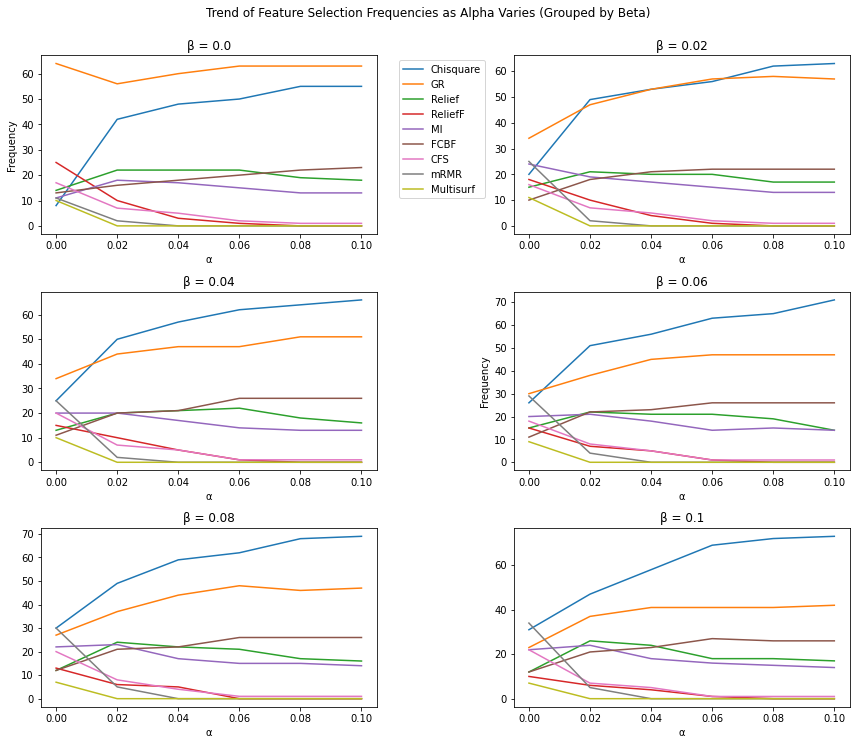

In [94]:
unique_alphas = sorted(df_results['beta'].unique())

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

algorithms = df_results.columns[2:]

for i, alpha_val in enumerate(unique_alphas):
    ax = axs[i]
    
    df_alpha = df_results[df_results['beta'] == alpha_val]
    
    for algo in algorithms:
        ax.plot(df_alpha['alpha'], df_alpha[algo], label=algo)
    
    ax.set_title(f'β = {alpha_val}')
    ax.set_xlabel('α')
    if i % 3 == 0:
        ax.set_ylabel('Frequency')
    ax.grid(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("Trend of Feature Selection Frequencies as Alpha Varies (Grouped by Beta)", y=1.03)
plt.show()


In [95]:
df_results

,alpha,beta,Chisquare,GR,Relief,ReliefF,MI,FCBF,CFS,mRMR,Multisurf
0,0.00,0.00,8,64,14,25,11,13,17,11,10
1,0.00,0.02,20,34,15,18,24,10,16,25,11
2,0.00,0.04,25,34,13,15,20,11,20,25,10
3,0.00,0.06,26,30,15,15,20,11,18,29,9
4,0.00,0.08,30,27,12,13,22,12,20,30,7
5,0.00,0.10,31,23,12,10,22,12,22,34,7
6,0.02,0.00,42,56,22,10,18,16,7,2,0
7,0.02,0.02,49,47,21,10,19,18,7,2,0
8,0.02,0.04,50,44,20,10,20,20,7,2,0
9,0.02,0.06,51,38,22,7,21,22,8,4,0


In [118]:
root = './optimalalphabeta/dfmrr_cont/'
for i in np.arange(0, 0.11, 0.02):
    for j in np.arange(0,0.11, 0.02):
        df_optimal = extract_rows_using_log(df2, i, j, 'fmrr')
        merge_features = pd.merge(df_new, df_optimal[['File','FeatureAlgo']], on=['File'])
        merge_features.to_csv(root+"dfmrr"+str(i)+"_"+str(j)+".csv", index=False)

In [119]:
root = './optimalalphabeta/dfwrr_cont/'
for i in np.arange(0, 0.11, 0.02):
    for j in np.arange(0,0.11, 0.02):
        df_optimal = extract_rows_using_log(df2, i, j, 'fwrr')
        merge_features = pd.merge(df_new, df_optimal[['File','FeatureAlgo']], on=['File'])
        merge_features.to_csv(root+"dfwrr"+str(i)+"_"+str(j)+".csv", index=False)

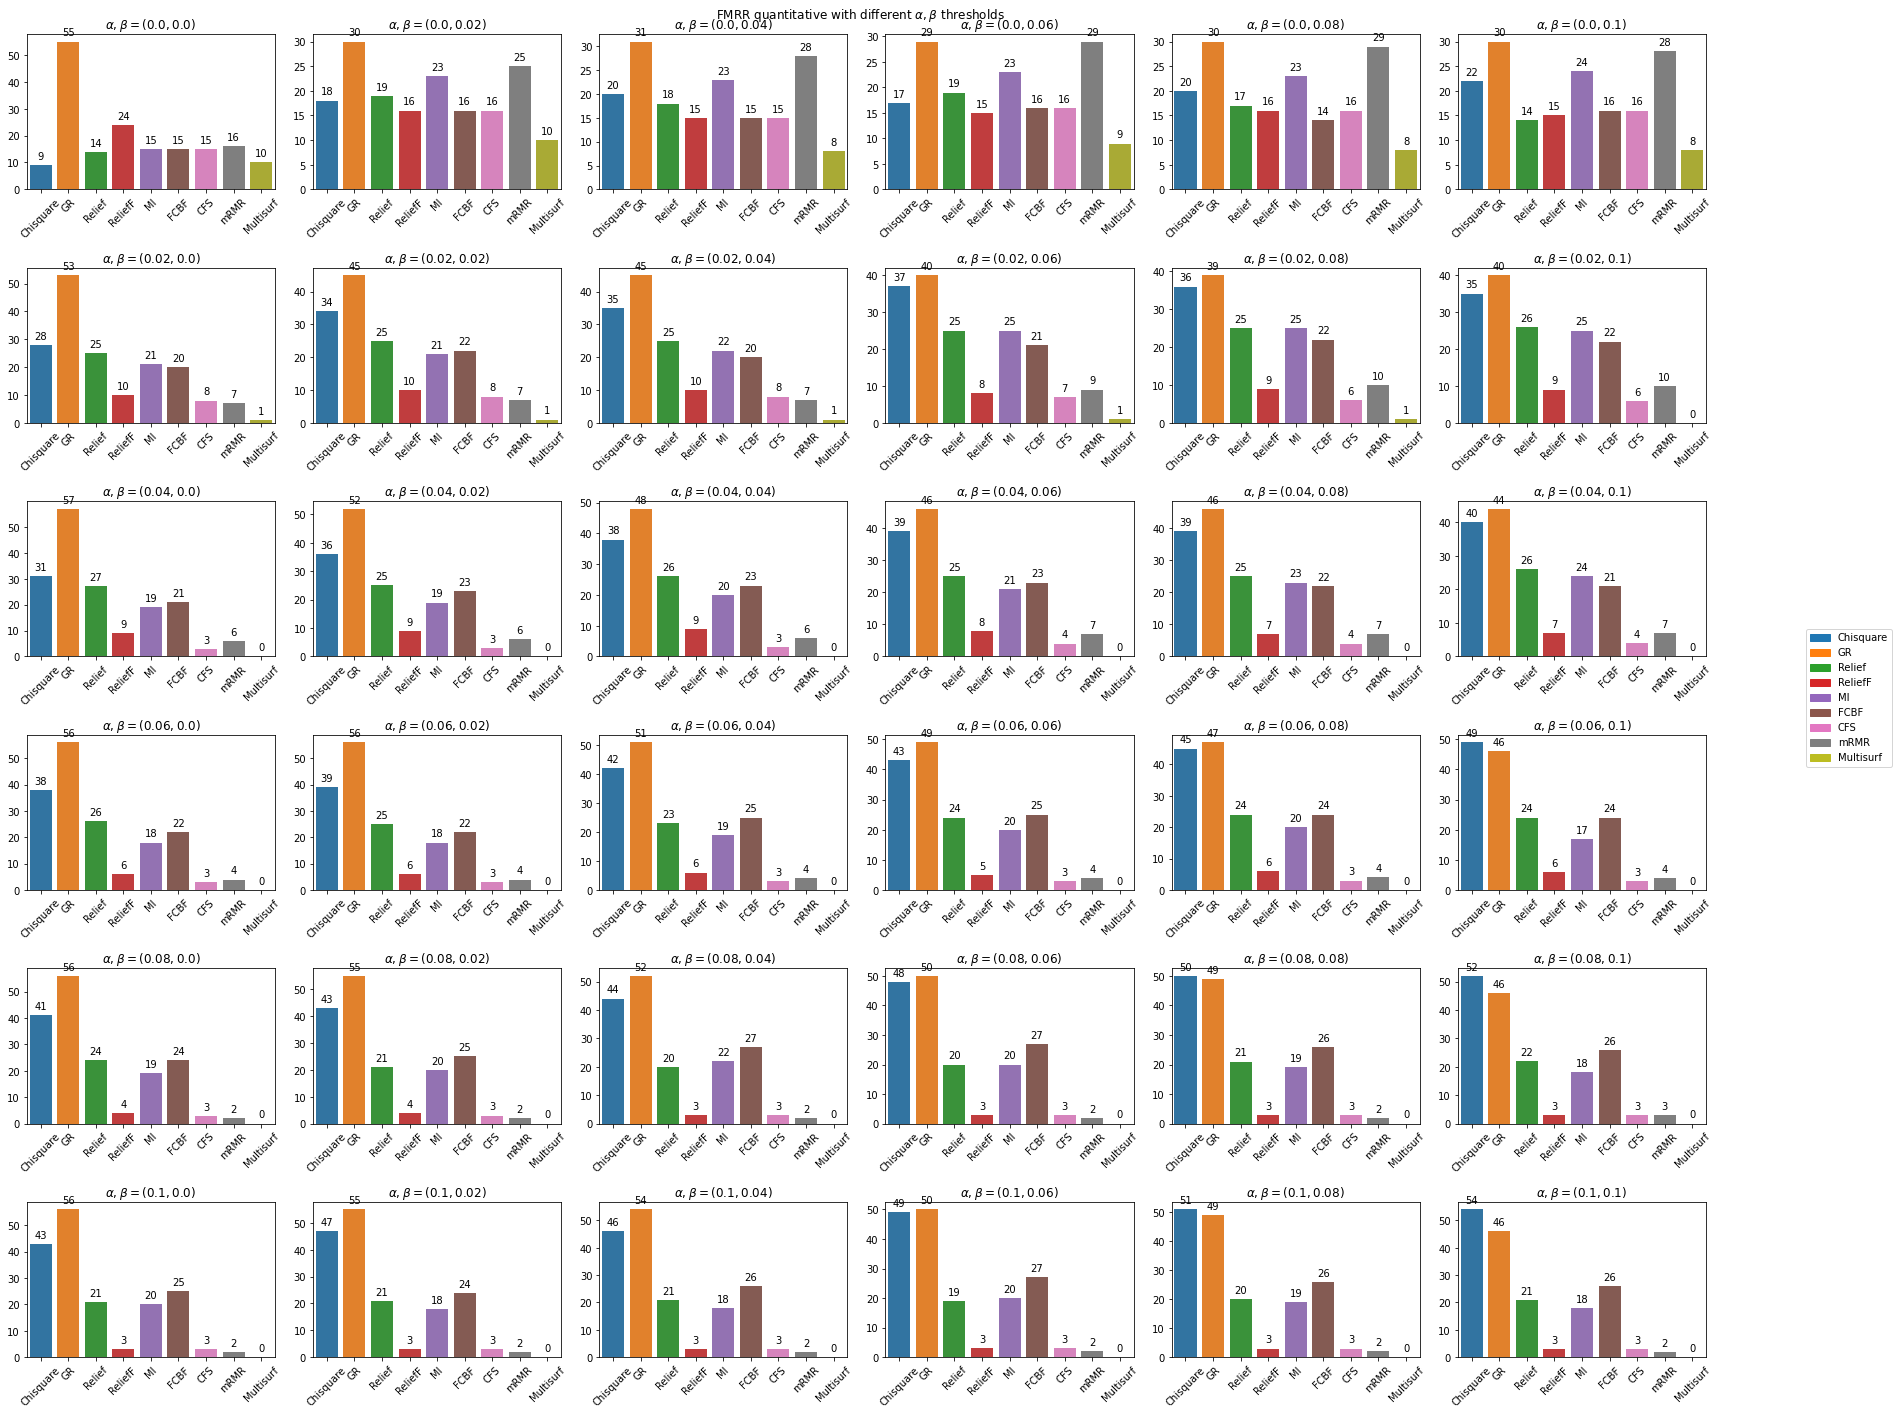

In [120]:
feature_algos = [
    'chisquare', 'GR', 'relief', 'relieff', 'MI',
    'fcbf', 'cfs', 'mrmr', 'multisurf'
]
renamed_algos = [
    'Chisquare', 'GR', 'Relief', 'ReliefF', 'MI',
    'FCBF', 'CFS', 'mRMR', 'Multisurf'
]
rename_dict = dict(zip(feature_algos, renamed_algos))

palette = sns.color_palette("tab10", len(feature_algos))
color_dict = {renamed_algos[i]: palette[i] for i in range(len(feature_algos))}

abs_path = "./optimalalphabeta/dfmrr_cont"

file_info = []
for file in os.listdir(abs_path):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)  # Convert to float
        file_info.append((alpha, beta, file))

file_info.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 20), tight_layout=True)
fig.suptitle('FMRR quantitative with different ' + r'$\alpha, \beta$' + ' thresholds')

results = []

for idx, (alpha, beta, file) in enumerate(file_info):
    df = pd.read_csv(os.path.join(abs_path, file))
    df['FeatureAlgo'] = df['FeatureAlgo'].map(rename_dict)  # Rename the algorithms
    value_counts = df['FeatureAlgo'].value_counts().reindex(renamed_algos, fill_value=0)
    
    results.append([alpha, beta] + value_counts.tolist())
    
    row, col = divmod(idx, 6)
    ax = axes[row][col]
    
    sns.barplot(ax=ax, x=value_counts.index, y=value_counts.values, palette=[color_dict[algo] for algo in value_counts.index])
    ax.set_title(r'$\alpha, \beta = ({}, {})$'.format(alpha, beta))
    ax.set_xticklabels(labels=value_counts.index, rotation=45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.4)
df_results = pd.DataFrame(results, columns=['alpha', 'beta'] + renamed_algos)

handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(renamed_algos))]
labels = renamed_algos
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

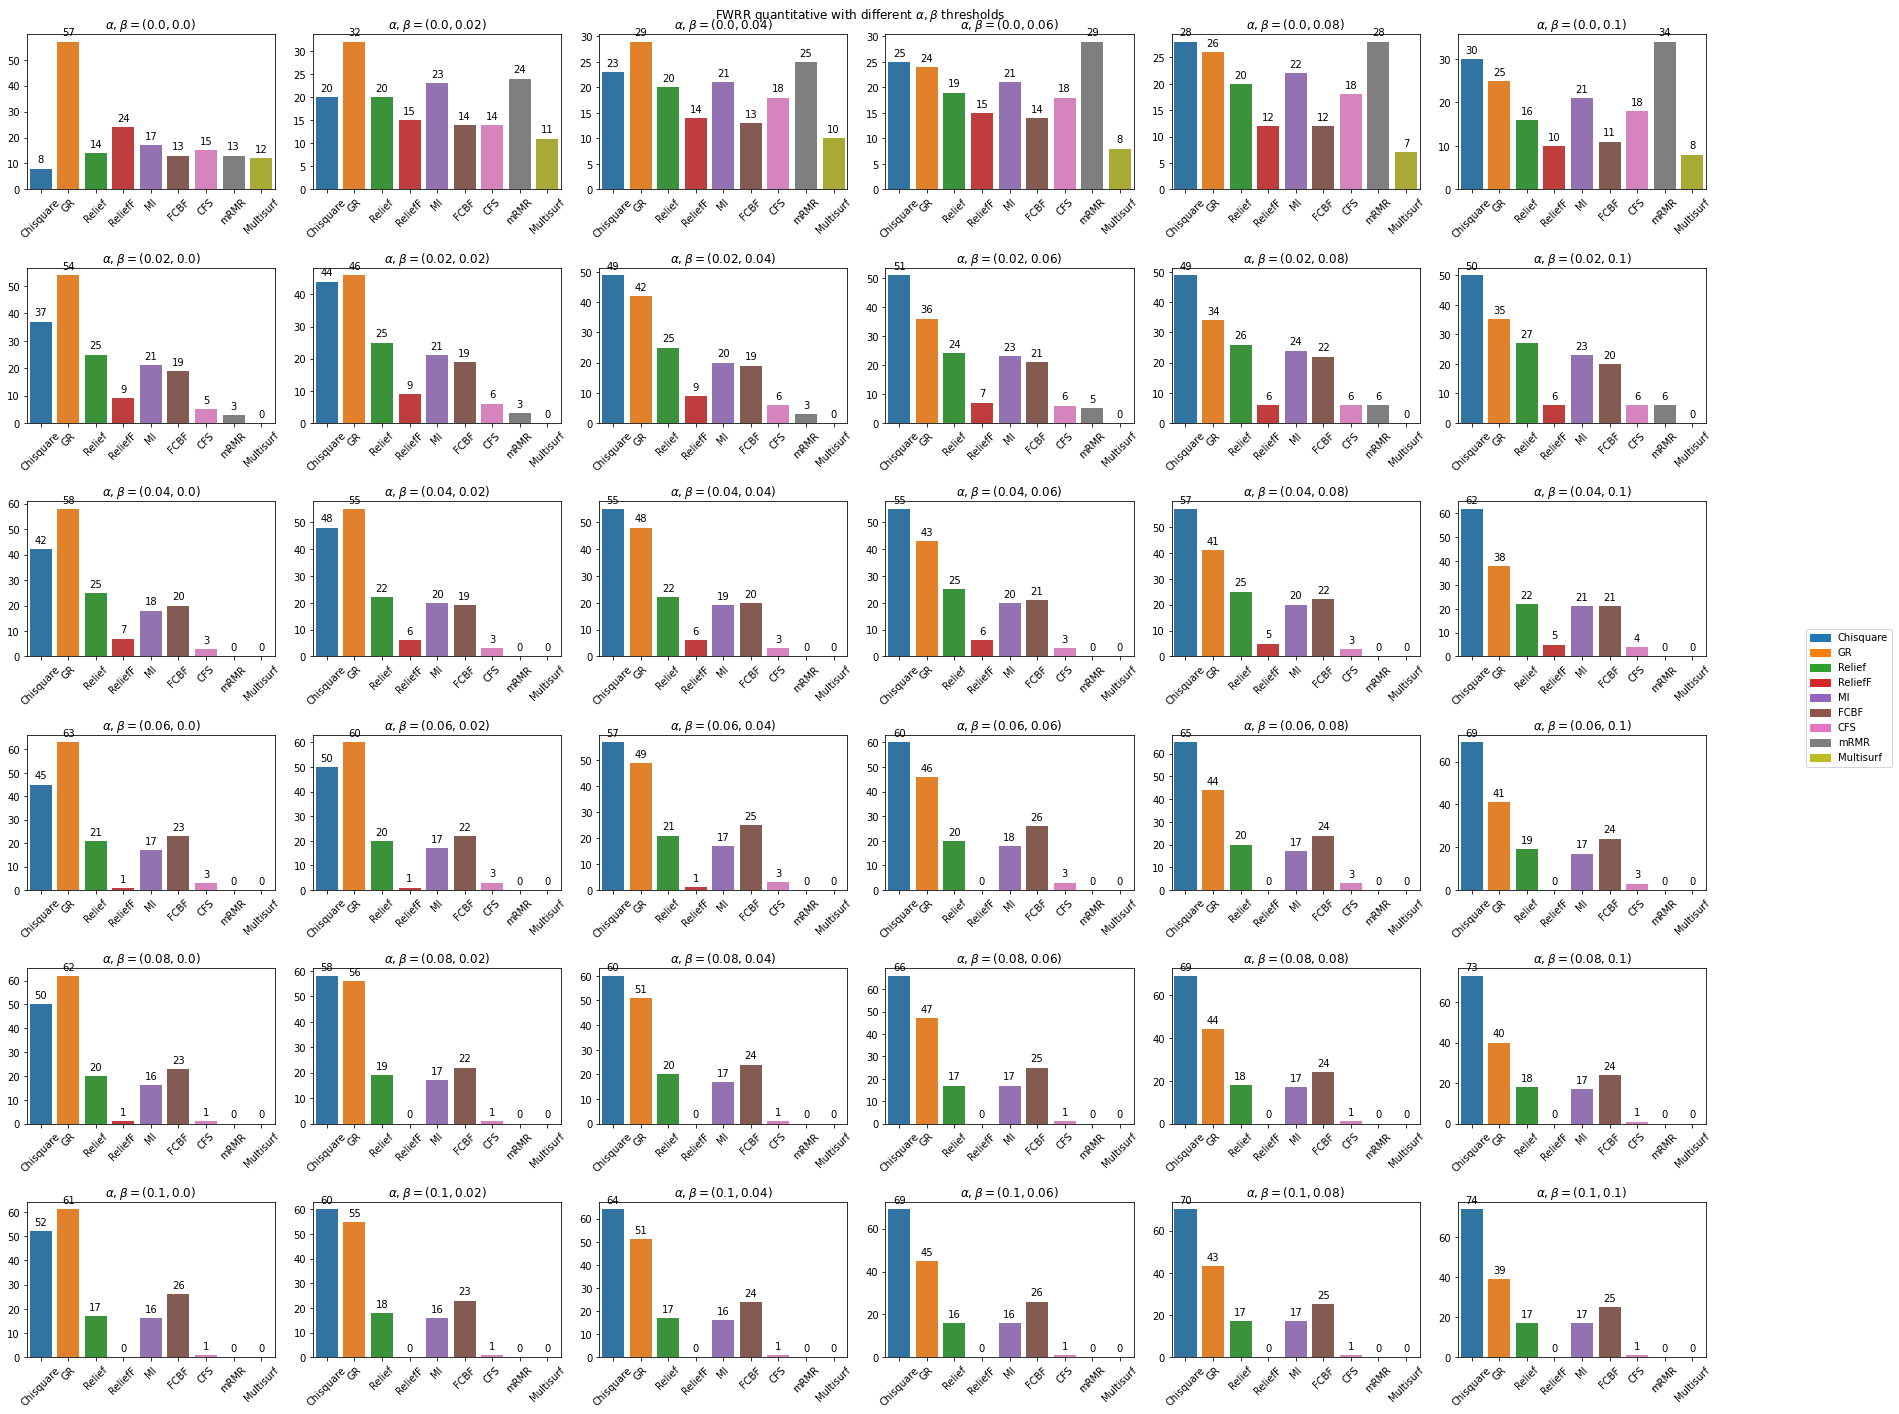

In [122]:
feature_algos = [
    'chisquare', 'GR', 'relief', 'relieff', 'MI',
    'fcbf', 'cfs', 'mrmr', 'multisurf'
]
renamed_algos = [
    'Chisquare', 'GR', 'Relief', 'ReliefF', 'MI',
    'FCBF', 'CFS', 'mRMR', 'Multisurf'
]
rename_dict = dict(zip(feature_algos, renamed_algos))

palette = sns.color_palette("tab10", len(feature_algos))
color_dict = {renamed_algos[i]: palette[i] for i in range(len(feature_algos))}

abs_path = "./optimalalphabeta/dfwrr_cont"

file_info = []
for file in os.listdir(abs_path):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)  # Convert to float
        file_info.append((alpha, beta, file))

file_info.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 20), tight_layout=True)
fig.suptitle('FWRR quantitative with different ' + r'$\alpha, \beta$' + ' thresholds')

results = []

for idx, (alpha, beta, file) in enumerate(file_info):
    df = pd.read_csv(os.path.join(abs_path, file))
    df['FeatureAlgo'] = df['FeatureAlgo'].map(rename_dict)  # Rename the algorithms
    value_counts = df['FeatureAlgo'].value_counts().reindex(renamed_algos, fill_value=0)
    
    results.append([alpha, beta] + value_counts.tolist())
    
    row, col = divmod(idx, 6)
    ax = axes[row][col]
    
    sns.barplot(ax=ax, x=value_counts.index, y=value_counts.values, palette=[color_dict[algo] for algo in value_counts.index])
    ax.set_title(r'$\alpha, \beta = ({}, {})$'.format(alpha, beta))
    ax.set_xticklabels(labels=value_counts.index, rotation=45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.4)
df_results = pd.DataFrame(results, columns=['alpha', 'beta'] + renamed_algos)

handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(renamed_algos))]
labels = renamed_algos
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

# Generate robust model as there is no common alpha, beta between EARR, FWRR and FMRR.  

In [52]:
import pandas as pd
import glob
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

# Define the folder path containing CSV files
folder_path = "./optimalalphabeta/dearr_cont"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and concatenate all CSV files into a single DataFrame
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

In [56]:
counts = df.groupby(['File', 'FeatureAlgo']).size().reset_index(name='Count')

majority = counts.loc[counts.groupby('File')['Count'].idxmax()]

majority = majority[['File', 'FeatureAlgo']]

majority.to_csv("majority_vote_regular.csv",index=False)

In [13]:
# Compute mean weighted score
df['WeightedScore'] = (
    (1 - df['Alpha'] - df['Beta']) * df['Accuracy']
    - df['Alpha'] * df['Time']
    - df['Beta'] * df['NumFeatures']
)

best_algo = (
    df.groupby(['File', 'FeatureAlgo'])['WeightedScore']
    .mean().reset_index()
    .sort_values(['File', 'WeightedScore'], ascending=[True, False])
    .drop_duplicates(subset=['File'])
    .rename(columns={'FeatureAlgo': 'BestAlgo'})
)

print(best_algo)


Accuracy: 0.79


In [14]:
#Merging all files of alpha beta to check
import os
import pandas as pd

# Define the directory containing the 36 files
directory = "./optimalalphabeta/dearr_cont"


# Initialize an empty list to store data
data_list = []

# Process each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):  # Ensure it's a CSV file
        # Extract alpha and beta from filename (e.g., "dfearr0.0_0.2.csv")
        try:
            parts = filename.replace("dearr", "").replace(".csv", "").split("_")
            alpha, beta = float(parts[0]), float(parts[1])
        except (IndexError, ValueError):
            print(f"Skipping invalid file: {filename}")
            continue  # Skip files that don't match expected pattern
        
        # Read the file
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)

        file_column = df.iloc[:, 0]  # First column (File)
        feature_algo_column = df.iloc[:, -1]  # Last column (FeatureAlgo)

        # Store extracted information
        for file_name, feature_algo in zip(file_column, feature_algo_column):
            data_list.append([file_name, alpha, beta, feature_algo])

# Create DataFrame
final_df = pd.DataFrame(data_list, columns=["File", "Alpha", "Beta", "FeatureAlgo"])

#final_df.to_csv("Datasetswithalphabetafeaturealgo.csv", index=False)
# Display the result
#print(final_df.head())  # Show first few rows

In [22]:
df_ensemble = pd.read_csv("df_ensemble_allfeatures.csv")

In [26]:
merged_df = pd.merge(final_df, df_ensemble, on=['File', 'FeatureAlgo'])

merged_df = merged_df[['File', 'Alpha', 'Beta', 'FeatureAlgo', 'Accuracy', 'Time FS', 'Features']]

print(merged_df.head(2))


                              File  Alpha  Beta FeatureAlgo  Accuracy  \
0  chronic_kidney_disease_full.csv   0.04  0.10          MI       1.0   
1  chronic_kidney_disease_full.csv   0.02  0.06          MI       1.0   

    Time FS  Features  
0  0.067336        10  
1  0.067336        10  


In [30]:
#weighted voting  - cost based method
merged_df['WeightedScore'] = (
    (1 - merged_df['Alpha'] - merged_df['Beta']) * merged_df['Accuracy']
    - merged_df['Alpha'] * merged_df['Time FS']
    - merged_df['Beta'] * merged_df['Features']
)

best_algo = (
    merged_df.groupby(['File', 'FeatureAlgo'])['WeightedScore']
    .mean().reset_index()
    .sort_values(['File', 'WeightedScore'], ascending=[True, False])
    .drop_duplicates(subset=['File'])
    .rename(columns={'FeatureAlgo': 'FeatureAlgo'})
)
best_algo.to_csv("majority_vote.csv",index=False)

In [36]:
#weighted voting 
mean_acc = merged_df.groupby(['File', 'FeatureAlgo'])['Accuracy'].mean().reset_index()

# Pick best algo per file
best_algo = (
    mean_acc
    .sort_values(['File', 'Accuracy'], ascending=[True, False])
    .drop_duplicates(subset='File')
    .rename(columns={'FeatureAlgo': 'FeatureAlgo'})
)
best_algo.to_csv("majority_vote.csv",index=False)

In [48]:
import pandas as pd

def get_top_feature_algo_by_borda(df, file_col='File', algo_col='FeatureAlgo', score_col='Accuracy'):
    """
    Computes the top-ranked FeatureAlgo for each File using Borda count based on Accuracy.

    Parameters:
    - df: DataFrame containing the data
    - file_col: column name for file identifiers
    - algo_col: column name for feature algorithms
    - score_col: column name for the score used in ranking (e.g., Accuracy)

    Returns:
    - DataFrame with columns ['File', 'TopFeatureAlgo']
    """
    borda_scores = []

    # Compute Borda scores within each file
    for file, group in df.groupby(file_col):
        ranked = group.sort_values(by=score_col, ascending=False).reset_index(drop=True)
        num_algos = len(ranked)

        for i, row in ranked.iterrows():
            score = num_algos - i - 1
            borda_scores.append({
                file_col: file,
                algo_col: row[algo_col],
                'BordaScore': score
            })

    # Aggregate Borda scores
    borda_df = pd.DataFrame(borda_scores)
    aggregated = borda_df.groupby([file_col, algo_col])['BordaScore'].sum().reset_index()

    # Get top FeatureAlgo per file
    top_algos = aggregated.sort_values(by=[file_col, 'BordaScore'], ascending=[True, False])
 #   top_feature_algo_df = top_algos.groupby(file_col).first().reset_index()
    top_algos.rename(columns={algo_col: 'FeatureAlgo'}, inplace=True)

    return top_algos


In [49]:
ranked_algos = get_top_feature_algo_by_borda(merged_df)
ranked_algos.to_csv("majority_vote.csv",index=False)

In [51]:
ranked_algos.to_csv("temp.csv",index=False)